In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
from torch.utils.data import DataLoader,Dataset,random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
audio_dir = "/raid/amana/lavish_multi_model/emotion_detection/data/raw_audio"

In [3]:
import numpy as np 
import soundfile as sf
import librosa

def getVggoud_proc(filename):
    audio_length = 1.5
    idx=0
    samples, samplerate = librosa.load(filename)

    if samples.shape[0] > 16000*(audio_length+0.1):
        sample_indx = np.linspace(0, samples.shape[0]-16000*(audio_length+0.1), num=1, dtype=int)
        samples = samples[sample_indx[idx]:sample_indx[idx]+int(16000*audio_length)]
    else:
        samples = np.tile(samples,int(audio_length))[:int(16000*audio_length)]

    samples[samples > 1.] = 1
    samples[samples < -1.] = -1
    
    return samples

def resample_audio(arr,sr):
    return librosa.util.fix_length(arr, size=sr)

In [4]:
from os import listdir
from os.path import isfile, join
import pandas as pd

def get_dataset(audio_dir):
    data = pd.read_csv("/raid/amana/lavish_multi_model/emotion_detection/data/text_data.csv")
    data['filename'] = [f'dia{a}_utt{b}' for a,b in zip(data['Dialogue_ID'],data['Utterance_ID'])]
    labels = list(data['Emotion'])
    onlyfiles = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f))]
    res = []
    shapes = []
    for a,label in zip(onlyfiles,labels):
        res1 = getVggoud_proc(audio_dir+"/"+a)
        shapes.append(res1.shape)
        res.append([res1,label])
    shapes = np.array(shapes)
    true_shapes = shapes>5000
    res = [a for a,b in zip(res,true_shapes) if b[0] == True]
    final_len = int(np.mean(shapes))
    final_dataset = [[resample_audio(a[0],final_len),a[1]] for a in res]
    return final_dataset


def get_dataset_2(audio_dir):
    data = pd.read_csv("/raid/amana/lavish_multi_model/emotion_detection/data/text_data.csv")
    data['filename'] = [f'dia{a}_utt{b}' for a,b in zip(data['Dialogue_ID'],data['Utterance_ID'])]
    labels = list(data['Emotion'])
    onlyfiles = [f for f in listdir(audio_dir) if isfile(join(audio_dir, f))]
    res = []
    shapes = []
    for a,label in zip(onlyfiles,labels):
        res1 = getVggoud_proc(audio_dir+"/"+a)
        shapes.append(res1.shape)
        res.append([res1,label])
    shapes = np.array(shapes)
    true_shapes = shapes>5000
    res = [a for a,b in zip(res,true_shapes) if b[0] == True]
    final_len = 16000
    final_dataset = [[resample_audio(a[0],final_len),a[1]] for a in res]
    return final_dataset

In [5]:
dataset = get_dataset_2(audio_dir)

## getting audio embeddings


In [3]:
# from transformers import AutoProcessor, Wav2Vec2Model
import torch as t
import numpy as np
t.cuda.set_device(8)



In [4]:
import warnings
warnings.filterwarnings("ignore")
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [10]:
from transformers import AutoProcessor, Wav2Vec2Model

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
emotion_label = {'anger' : 1, 'disgust' : 2, 'fear' : 3,
                 'joy' : 4, 'neutral' : 5, 'sadness' : 6, 'surprise' : 0}

In [12]:
def get_final_dataset(dataset):
    final_dataset = []
    for a in dataset:
        inputs = processor(a[0], sampling_rate=16000, return_tensors="pt").to(device)
        with t.no_grad():
            outputs = model(**inputs).extract_features
            final_dataset.append([outputs.squeeze(0),emotion_label[a[1]]])
            


2024-01-03 22:16:38.335513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 22:16:40.421249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Defining model

In [6]:
def test(model,test_loader,device):
    
    def accuracy(y_true, y_pred):
        eq = t.eq(y_true, y_pred).int()
        return sum(eq)/len(eq)

    with t.no_grad():
        model.eval()
        for inputs,labels in test_loader:
            outputs = model(inputs.to(device))
            outputs1 = outputs.detach().cpu()
            acc += accuracy(labels,outputs1)
        print(f"accuracy: {(acc/len(test_loader))*100: 0.2f}%")

In [18]:
train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(final_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1,shuffle=False)

In [16]:
t.save(train_dataloader.dataset, 'train_dataset.pth')

# Save the testing DataLoader
t.save(test_dataloader.dataset, 'test_dataset.pth')


In [7]:
train_dataloader = t.load("train_dataset.pth")
test_dataloader = t.load("test_dataset.pth")

In [12]:
# class EmotionCNN(nn.Module):
#     def softmax(self,x):
#         e_x = t.exp(x - t.max(x))
#         return e_x / e_x.sum()
    
#     def __init__(self, num_classes):
#         super(EmotionCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
#         self.conv5 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#         self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
#         self.fc1 = nn.Linear(512,256)
#         self.fc2 = nn.Linear(256,128)
#         self.fc3 = nn.Linear(128,64)
#         self.fc4 = nn.Linear(64, num_classes)

#     def conv_output(self,x):
#         x = self.pool(t.relu(self.conv1(x)))
#         x = self.pool(t.relu(self.conv2(x)))
#         x = self.pool(t.relu(self.conv3(x)))
#         x = self.pool(t.relu(self.conv4(x)))
#         x = self.pool(t.relu(self.conv5(x)))
#         x = F.adaptive_avg_pool2d(x,(1,1))
#         return x
    
#     def forward(self, x):
#         x = self.pool(t.relu(self.conv1(x)))
#         x = self.pool(t.relu(self.conv2(x)))
#         x = self.pool(t.relu(self.conv3(x)))
#         x = self.pool(t.relu(self.conv4(x)))
#         x = self.pool(t.relu(self.conv5(x)))
#         x = F.adaptive_avg_pool2d(x,(1,1))
#         x = x.view(-1, 512)
#         x = t.relu(self.fc1(x))
#         x = t.relu(self.fc2(x))
#         x = t.relu(self.fc3(x))
#         x = t.relu(self.fc4(x))
#         return x
    
class EmotionMLP(nn.Module):
    def softmax(self,x):
        e_x = t.exp(x - t.max(x))
        return e_x / e_x.sum()
    
    def __init__(self, num_classes):
        super(EmotionMLP, self).__init__()
        self.input_matrix = nn.Parameter(t.rand(71,1))
        self.fc1 = nn.Linear(512,64)
        self.fc2 = nn.Linear(64, num_classes)

    
    def forward(self, x):
        x = t.matmul(x.t(),self.input_matrix)
        x = x.view(-1, 512)
        x = t.relu(self.fc1(x))
        x = t.relu(self.fc2(x))
        x = t.sigmoid(x)
        return x

In [13]:
num_classes = 7
model = EmotionMLP(num_classes).to(device)

x = t.rand(71,512)
model(x.to(device)).shape

torch.Size([1, 7])

In [14]:
num_classes = 7
model = EmotionMLP(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.0001)

In [15]:
def train(model,train_loader,optimizer,criterion,num_epochs,device):
    loss_arr = []
    for epoch in tqdm(range(num_epochs)):
        # model.train()
        total_loss = 0
        for x,y in train_loader:
            x = x.squeeze(0)
            # Forward pass
            outputs = model(x.to(device))
            loss = criterion(outputs,t.tensor([y]).to(device)).to(device)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_arr.append(total_loss/len(train_loader))
        if epoch%10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(train_loader)}')
    return loss_arr

num_epochs = 150
lossarr = train(model,train_dataloader,optimizer,criterion,num_epochs,device)

  1%|          | 1/150 [00:07<18:45,  7.55s/it]

Epoch 1/150, Training Loss: 1.8298888132056328


  7%|▋         | 11/150 [01:19<17:15,  7.45s/it]

Epoch 11/150, Training Loss: 1.8240977129202227


 14%|█▍        | 21/150 [02:38<16:38,  7.74s/it]

Epoch 21/150, Training Loss: 1.8233445853283639


 21%|██        | 31/150 [04:03<17:10,  8.66s/it]

Epoch 31/150, Training Loss: 1.8236466202207222


 27%|██▋       | 41/150 [05:28<15:01,  8.27s/it]

Epoch 41/150, Training Loss: 1.8231961384527906


 34%|███▍      | 51/150 [06:50<12:37,  7.66s/it]

Epoch 51/150, Training Loss: 1.8232704889915474


 41%|████      | 61/150 [08:15<12:44,  8.59s/it]

Epoch 61/150, Training Loss: 1.8216890065867626


 47%|████▋     | 71/150 [09:43<11:06,  8.44s/it]

Epoch 71/150, Training Loss: 1.821282796248938


 54%|█████▍    | 81/150 [11:05<08:59,  7.82s/it]

Epoch 81/150, Training Loss: 1.8206737636878236


 61%|██████    | 91/150 [12:32<08:38,  8.79s/it]

Epoch 91/150, Training Loss: 1.8205802249446494


 67%|██████▋   | 101/150 [14:05<07:33,  9.25s/it]

Epoch 101/150, Training Loss: 1.8187515271107784


 74%|███████▍  | 111/150 [15:24<04:43,  7.27s/it]

Epoch 111/150, Training Loss: 1.8179409355085556


 81%|████████  | 121/150 [16:36<03:10,  6.58s/it]

Epoch 121/150, Training Loss: 1.816842869613861


 87%|████████▋ | 131/150 [17:55<02:49,  8.93s/it]

Epoch 131/150, Training Loss: 1.816568223857777


 94%|█████████▍| 141/150 [19:18<01:11,  7.97s/it]

Epoch 141/150, Training Loss: 1.815521664332009


100%|██████████| 150/150 [20:25<00:00,  8.17s/it]


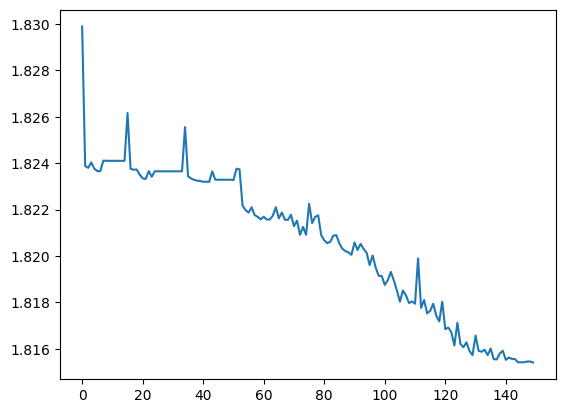

In [16]:
plt.plot(range(150),lossarr)

In [21]:
def test(model,test_loader,device):
    
    def accuracy1(y_true, y_pred):
        eq = t.eq(y_true, y_pred).int()
        return sum(eq)/len(eq)
    
    acc = 0
    with t.no_grad():
        model.eval()
        for x,y in test_loader:
            x = x.squeeze(0)
            outputs = model(x.to(device))
            outputs1 = outputs.detach().cpu()
            outputs2 = t.argmax(outputs1, dim=1)
            acc += accuracy1(t.tensor([y]),outputs2)
        print(f"accuracy: {((acc/len(test_loader))*100)}")
        
test(model,test_dataloader,device)

accuracy: 44.09268264770508
